<a href="https://colab.research.google.com/github/DarioCarolla/Time-Series-Analysis/blob/master/SDMTAS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Streaming Data Management and Time Series Analysis Project

### Dario Carolla Mat. 807547

## Librerie

Importazioni delle librerie necessarie

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

Mount per l'utilizzo di Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Caricamento dei dati

In [21]:
# Path Google Drive
data_path = '/content/drive/My Drive/SDMTAS_Project/time_series_dataset.csv'
# Read data
df = pd.read_csv(data_path, sep = ';')

### Data Analysis

In [68]:
bold_txt = '\033[1m'
print(bold_txt + 'Head del dataset:')
print(df.head())
print()
print('--------------------------')
print()
print(bold_txt + 'Informazioni sul dataset:')
print(df.info())

Head del dataset:
                 value
Data                  
2010-01-01   41.651044
2010-01-02  131.286604
2010-01-03  117.388117
2010-01-04  116.461280
2010-01-05  123.823765

--------------------------

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2010-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   3287 non-null   float64
dtypes: float64(1)
memory usage: 51.4 KB
None


Il dataset è costituito da due colonne:
*   Data: rappresenta il momento in cui è stato rilevato il valore. (Necessita la trasformazione di Date-Time)
*   value: rappresenta il valore dei prezzi del mercato energetico.

Sono presenti 3287 valori e non sono presenti valori nulli.

In [33]:
df.Data = pd.to_datetime(df.Data)
df.dtypes

Data     datetime64[ns]
value           float64
dtype: object

In [57]:
df.set_index('Data', inplace = True)
df.head()

SyntaxError: ignored

Rappresentazione grafica della serie storica

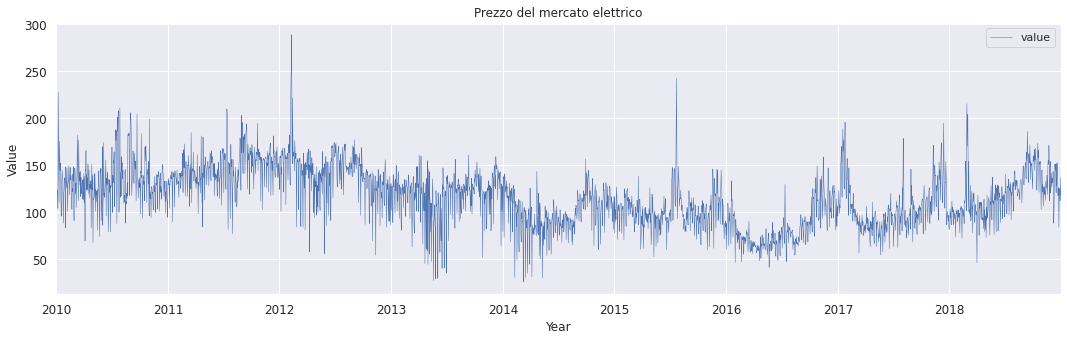

In [56]:
df.plot(figsize=(18,5), linewidth=0.5, fontsize=12)
plt.title('Prezzo del mercato elettrico')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12);